# Analysis 1
### Trying to find out
---

## Does University towns have their mean housing prices less effected by recessions?
---

In [17]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from scipy.stats import ttest_ind
from matplotlib import pylab, mlab, pyplot
import seaborn as sns

The following data files is Used:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. 

In [18]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'District of Columbia':'DC'
}

In [19]:
# This dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [20]:
#Loading file to data frame.
university_towns=pd.read_table('Data/txt/university_towns.txt')
university_towns.head()

,Alabama[edit]
0,Auburn (Auburn University)[1]
1,Florence (University of North Alabama)
2,Jacksonville (Jacksonville State University)[2]
3,Livingston (University of West Alabama)[2]
4,Montevallo (University of Montevallo)[2]


### As in the university_towns.txt the following cleaning needs to be done:
    1. For 'State' Removing characters from '[' to the end 
    2. For 'RegionName', removing every character from " (" to the end.
    3. May need to remove newline character '\n'

In [21]:
def get_list_of_university_towns():
    
    #Clean data remove [edit] from each state name
    #Remove starting from( in the regionName
    lst,state,statelist,region,regionlist=[],[],[],[],[]
    with open('Data/txt/university_towns.txt') as f:
        for line in f:
            if '[ed' in line:
                 #Clean data remove [edit] 
                state=re.sub(r'\[.*\]','',line).rstrip()
            else:
                if '(' in line:
                     #Clean data remove [edit] 
                    region= line[:line.index('(')-1]
                    region=re.sub(r"\(.*\)","",region)
                    region=re.sub(r"\[.*\]","",region).rstrip()
                else:
                    #If ( is not their remove the \n and white space so rstrip is used
                    region=re.sub(r"\n","",line).rstrip()
                #append every state name and region name to the list.
                statelist.append(state)
                regionlist.append(region)

    d=pd.DataFrame({'State':statelist,'RegionName':regionlist})
    d=d[['State','RegionName']]
    return d
a=get_list_of_university_towns()
a.head()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo


### For GDP
Clean the GDP data and finding the following:

    1.Recession Start quater   
    2.Recession End quarter

In [22]:
#method for the clean of gdplev data 
def recession_clean_data():
    #get the xls file
    x=pd.ExcelFile('Data/CSV/GDP/gdplev.xls')
    #skip the header file
    recession=x.parse(skiprows=7)
    
    #take only Unnamed:4 and Unnamed:5 which contains Quater and GDP
    recession=recession[['Unnamed: 4','Unnamed: 5']]
    #rename this columns
    recession.rename(columns={'Unnamed: 4':'Quater','Unnamed: 5':'GDP'},inplace=True)
    
    #get the index of the 2000q1 from where we need to analyzed the data
    index_2000=recession[recession['Quater']=='2000q1'].index

    # droping the data before 2000q1 data
    recession.drop(recession.index[:index_2000.item()],inplace=True)
    
    return recession
recession_clean_data().head()

,Quater,GDP
212,2000q1,10031.0
213,2000q2,10278.3
214,2000q3,10357.4
215,2000q4,10472.3
216,2001q1,10508.1


In [23]:
def get_recession_start():
    recession = recession_clean_data()
    # recession difference so i used diff with shift(-1) and shift(-2) which shifts the row by one and two respectively.
    abc=recession[(recession['GDP'] > recession['GDP'].shift(-1)) & (recession['GDP'].shift(-1) > recession['GDP'].shift(-2))]
    
    #return the start quater of recession
    return  abc['Quater'].values[0]
get_recession_start()

'2008q3'

In [24]:
def get_recession_end():
    x=pd.ExcelFile('Data/CSV/GDP/gdplev.xls')
    recession=x.parse(skiprows=7)
    recession=recession[['Unnamed: 4','Unnamed: 5']]
    recession.rename(columns={'Unnamed: 4':'Quater','Unnamed: 5':'GDP'},inplace=True)
    
    #Cannot use recession_clean_data() method because want to find from the index where the recession starts
    index_2000=recession[recession['Quater']== get_recession_start()].index

    # droping the data before 2000q1 data
    recession.drop(recession.index[:index_2000.item()],inplace=True)
    #find the recession and ending with two consecutive quarters of GDP growth
    abc=recession[(recession['GDP'] < recession['GDP'].shift(-1)) & (recession['GDP'].shift(-1) < recession['GDP'].shift(-2))]

    return  abc['Quater'].values[2]   
get_recession_end()

'2009q4'

In [25]:
def get_recession_bottom():
    x=pd.ExcelFile('Data/CSV/GDP/gdplev.xls')
    recession=x.parse(skiprows=7)
    recession=recession[['Unnamed: 4','Unnamed: 5']]
    recession.rename(columns={'Unnamed: 4':'Quater','Unnamed: 5':'GDP'},inplace=True)
    
    index_2000=recession[recession['Quater']==get_recession_start()].index

    # droping the data before 2000q1 data
    recession.drop(recession.index[:index_2000[0]],inplace=True)

    return recession[recession['GDP']==recession['GDP'].min()]['Quater'].item()
get_recession_bottom()

'2009q2'

In [26]:
# convert_housing_data_to_quarters():

import csv
import pandas as pd


home=pd.read_csv('Data/CSV/City_Zhvi_AllHomes.csv')

#Drop the columns 
columns_to_drop = ['1996','1997','1998','1999']
home = home[[col for col in home.columns if col[:4] not in columns_to_drop]]
columnss=['RegionID','Metro','CountyName','SizeRank']
home =home[[col for col in home.columns if col not in columnss]]
#Range of year in the year list which want to convert in quater form
year=[]
for a in range(2000,2017):
    year.append(str(a))
# print(year)
q1=['01','02','03']
q2=['04','05','06']
q3=['07','08','09']
q4=['10','11','12']
for a in year:
    for col in home.columns:
        #for each columns in we need only year so slicing it and compare with the year list
        if col[:4] == a:

            #As year is in 2000-01,2000-02 and so on so slicing the last two and compare with the list in quarter1
            if col[-2:] in q1:
                home[col[:4]+'q1'] = home[[col[:4]+'-01',col[:4]+'-02',col[:4]+'-03']].mean(axis=1)
            if col[-2:] in q2:
                home[col[:4]+'q2'] = home[[col[:4]+'-04',col[:4]+'-05',col[:4]+'-06']].mean(axis=1)

            #Special Case in the given data 2016 has only data till 2016-08 so taking that in consideration
            if col[-2:] in q3 and col[:4] =='2016':
                home[col[:4]+'q3'] = home[[col[:4]+'-07',col[:4]+'-08']].mean(axis=1)
                continue

            if col[-2:] in q3:
                home[col[:4]+'q3'] = home[[col[:4]+'-07',col[:4]+'-08',col[:4]+'-09']].mean(axis=1)

            if col[-2:] in q4:
                home[col[:4]+'q4'] = home[[col[:4]+'-10',col[:4]+'-11',col[:4]+'-12']].mean(axis=1)

#appending '-' to every year and drop columns from the dataframe with 2000-,2001-,2002-,...,2016- which we already convert to 2000q1...2016q3
year = [a+'-' for a in year ]

home = home[[col for col in home.columns if col[:5] not in year]]
#Replacing with states which is define in second block
home['State']=home['State'].replace(states)

#set the index of the state and regionName
home.set_index(['State','RegionName'],drop=True,inplace=True)
home.head()


,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0


In [27]:
rec_start=get_recession_start()
rec_bottom=get_recession_bottom()

#Housing data in quarters
home=home

#University town list
university_town = get_list_of_university_towns()

#Recession ratio=Rec_start/Rec_bottom
prices_begin=home[rec_start]
prices_end=home[rec_bottom]

home['difference']=((prices_begin-prices_end)/prices_begin)*100


#Set multi-index of dataframe to match multi-index of home dataframe
university_town = university_town.set_index(['State', 'RegionName'])

#Droping all na 
university_town=university_town.dropna()

#In order to conduct t test we need to drop anything from table which is not a number
ratio_college = home.loc[list(university_town.index)]['difference'].dropna()

# Get non-university towns
ratio_not_college_towns = set(home.index) - set(ratio_college.index)

ratio_not_college =home.loc[list(ratio_not_college_towns),:]['difference'].dropna()
# ratio_college[ratio_college<1].count()
# ratio_college.count()    
#     #We collect our statistic and p-value, then we evaluate whether university towns or non-university towns are better off during recessions
#     statistic, p_value = tuple(stats.ttest_ind(ratio_college, ratio_not_college))

#     outcome = statistic < 0

#     different = p_value < 0.05

#     better = ["non-university town", "university town"]
    
#     return (different, p_value, better[outcome])
# run_ttest()




In [28]:
#Making new DataFrame of % with difference between recession start and end with respect to recession start.
state,college_Per,Non_College_Per=[],[],[]
for statess in ratio_not_college.index.levels[0]:
    state.append(statess)
    if statess in ratio_college.index.levels[0].tolist():
        college_Per.append(ratio_college[statess].mean())
    else:
        college_Per.append(np.NaN)
    Non_College_Per.append(ratio_not_college[statess].mean())
dict_for_df = {'States':state,'University Town':college_Per,'Non University Town':Non_College_Per}
df=pd.DataFrame(dict_for_df)
df=df.dropna()
df.head()
# import us_state_abbrev

,Non University Town,States,University Town
0,3.721850,Alabama,1.767053
1,3.472900,Alaska,9.654621
2,8.010183,Arizona,7.556486
3,0.556059,Arkansas,2.235482
4,11.581632,California,10.021172


In [29]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
df['States']=df['States'].replace(us_state_abbrev)
df.set_index('States',inplace=True)
df.head()

,Non University Town,University Town
States,,
AL,3.721850,1.767053
AK,3.472900,9.654621
AZ,8.010183,7.556486
AR,0.556059,2.235482
CA,11.581632,10.021172


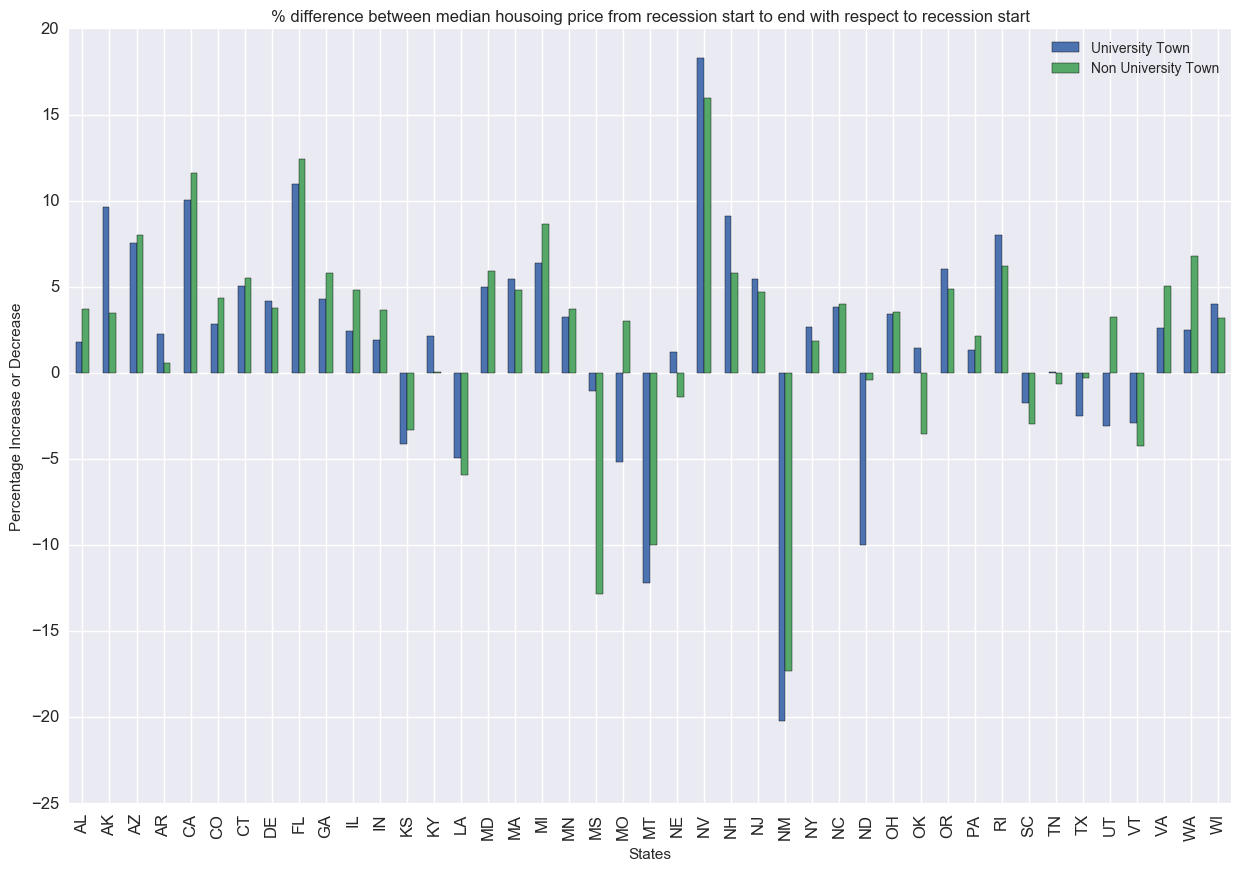

In [15]:
# sns.barplot(x='States',y=['College Per','Non_College_Per'],data=df)
az=df[['University Town','Non University Town']].plot(kind='bar',figsize=(15, 10), legend=True, fontsize=12)
az.set_title("% difference between median housoing price from recession start to end with respect to recession start")
az.set_xlabel("States")
az.set_ylabel("Percentage Increase or Decrease")
# pylab.savefig('Analysis1/Analysis1_University_NonUniversity.png')

# So from the figure we can see in most of the states <font color='blue'>_University Town_</font> got less difference in % value  <font color='red'>_recession_</font> compare to <font color='blue'> _Non-University Town_</font>

### So less value in % so less is decrease which is good in value so one can say that university town got less impact than non-university town